<a href="https://colab.research.google.com/github/hsiangwei0903/Fine-Grained-Object-Recognition/blob/dev%2Fravi%2Ftent/TrainingAndTent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import numpy as np
import statistics
%matplotlib inline

In [3]:
cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/

/content/drive/.shortcut-targets-by-id/1beXLuTyfFnOo3t19p65wHXF-qaxghvjI/ENGINE: Wyze


In [4]:
dataset = ImageFolder('./Images/stanfordImages/Images')

In [5]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

In [6]:
len(dataset)


20580

In [7]:
random_seed = 45
torch.manual_seed(random_seed);
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


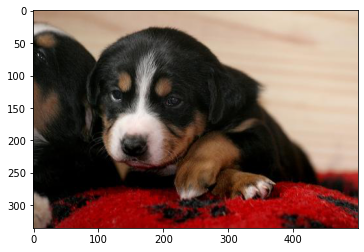

In [9]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [10]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),    
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

corrupt_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(15,15), sigma=(3, 3)),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=(.5,1.5), saturation=(1,1.25)),
    transforms.ToTensor(),         
])

In [12]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
corrupt_test_dataset = DogBreedDataset(test_ds, corrupt_transform)

119


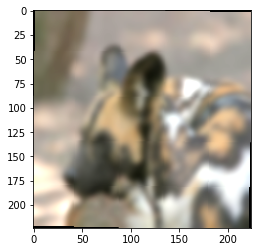

In [13]:
img, label = corrupt_test_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [14]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
corrupt_test_dl = DataLoader(corrupt_test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [15]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

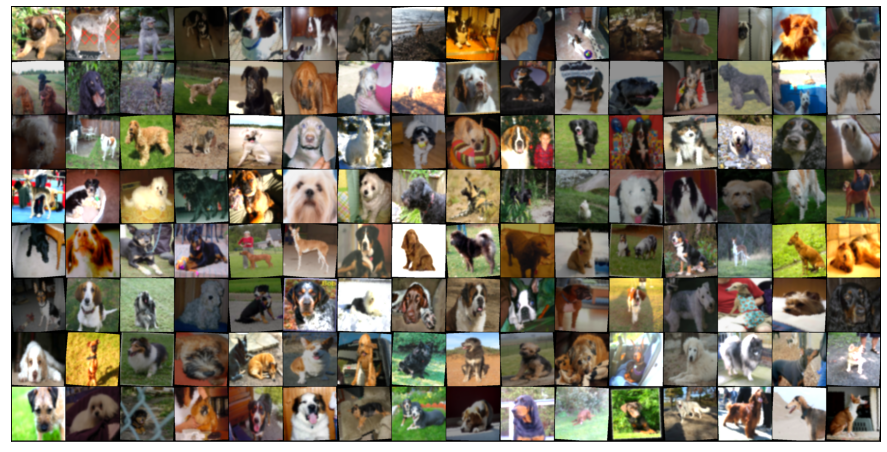

In [16]:
show_batch(corrupt_test_dl)


In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # print(outputs[0])
    # print(preds[0])
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        # print(out[0])
        # print(targets[0])
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def wyze_validation_step(self, batch):
        img, targets = batch
        outs = self(img)                                  # Change model object here
        _, preds = torch.max(outs, dim=1)
        labelslist = targets.detach().tolist()
        predlist = preds.detach().tolist()

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def validation_epoch_end_wyze(self, outputs):
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = statistics.mean(batch_acc)
        return {'val_acc': epoch_acc}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [19]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
model2 = DogBreedPretrainedResnet34()
model2

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [22]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [23]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model2, device);

cuda


In [24]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([112,  23,  46,  78,  85,  35,  39,  77,  22,  49,  70,  55,  68,   3,
         29,  83,  88,  96,  45,  90, 101, 111,  54,  33,  17,  99,  40,  28,
         54,   8,  84,  29,  81,  91,  64,  75, 107, 117,  44,  43,  69,  94,
         46,  80,   1,  13,  70, 111,  28,  47,  94,  18,  46,   2,   2,   6,
         19,  57,  23,  46,  56,  80,  73,  15], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-5.1278, -4.9813, -5.5657,  ..., -5.3731, -5.4315, -5.5061],
        [-5.2237, -5.7099, -6.4569,  ..., -4.9026, -5.4239, -5.6204],
        [-5.1598, -4.8328, -7.2360,  ..., -4.6552, -4.9731, -5.1384],
        ...,
        [-4.7026, -4.7375, -7.0894,  ..., -5.0604, -5.3620, -5.6631],
        [-5.1347, -5.3362, -6.8801,  ..., -5.1289, -4.6467, -4.9919],
        [-5.1235, -5.3218, -6.1337,  ..., -5.2807, -4.9176, -5.2629]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [25]:
from tqdm.notebook import tqdm


In [26]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    # for batch in val_loader:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate_wyze(model, val_loader):
    # for batch in val_loader:
    outputs = [model.wyze_validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end_wyze(outputs)

In [27]:
evaluate(model2, val_dl)                 # change model object here


{'val_acc': 0.010416666977107525, 'val_loss': 5.157461166381836}

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.4091, val_loss: 1.5662, val_acc: 0.6315


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.1108, val_loss: 1.1450, val_acc: 0.6693


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.8600, val_loss: 1.3438, val_acc: 0.6354


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.7124, val_loss: 1.2572, val_acc: 0.6413


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.5855, val_loss: 1.0753, val_acc: 0.6875


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.4558, val_loss: 1.0308, val_acc: 0.7044


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.3292, val_loss: 0.9257, val_acc: 0.7246


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.2177, val_loss: 0.8238, val_acc: 0.7526


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.1447, val_loss: 0.7533, val_acc: 0.7786


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.1138, val_loss: 0.7487, val_acc: 0.7819


In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1116, val_loss: 0.7432, val_acc: 0.7806


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1077, val_loss: 0.7479, val_acc: 0.7767


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0995, val_loss: 0.7402, val_acc: 0.7767


In [ ]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0985, val_loss: 0.7399, val_acc: 0.7754


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0974, val_loss: 0.7355, val_acc: 0.7806


In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned.pth'
torch.save(model2.state_dict(), weights_fname)

In [ ]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

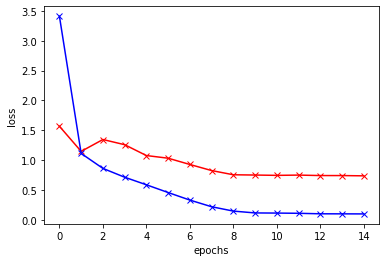

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

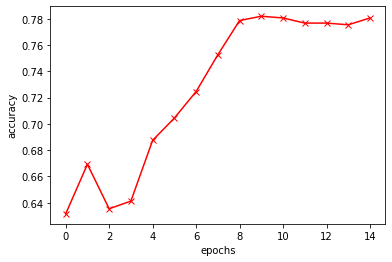

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [28]:
saved_model = DogBreedPretrainedResnet34()
saved_model.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned.pth"))

<All keys matched successfully>

In [29]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
corrupt_test_dl = DeviceDataLoader(corrupt_test_dl, device)

# moving model to gpu
to_device(saved_model, device);

cuda


In [30]:
evaluate(saved_model, test_dl) 

{'val_acc': 0.7861713767051697, 'val_loss': 0.7101448774337769}

In [64]:
evaluate(saved_model, corrupt_test_dl) 

{'val_acc': 0.26660287380218506, 'val_loss': 3.3868637084960938}

In [30]:
our_dataset = ImageFolder('./Images/test')

In [ ]:
our_dataset.classes

['n02085620-Chihuahua',
 'n02091032-Italian_greyhound',
 'n02093428-American_Staffordshire_terrier',
 'n02097047-miniature_schnauzer',
 'n02099712-Labrador_retriever',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02113799-standard_poodle']

In [ ]:
len(our_dataset)


88

n02085620-Chihuahua
<class 'PIL.Image.Image'>


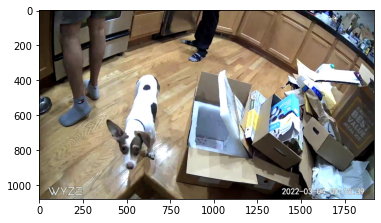

In [ ]:
img, label = our_dataset[6]
print(our_dataset.classes[label])
plt.imshow(img)
print(type(img))

In [31]:
wyze_dataset = DogBreedDataset(our_dataset, test_transform)
len(wyze_dataset)


88

0


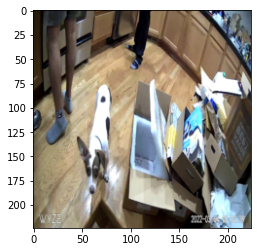

In [ ]:
img, label = wyze_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [32]:
wyze_dl = DataLoader(wyze_dataset, 10, num_workers = 2, shuffle=True, pin_memory = True)

In [33]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
wyze_dl = DeviceDataLoader(wyze_dl, device)


# moving model to gpu
to_device(saved_model, device);

cuda


In [34]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        saved_model.eval()
        outs = saved_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        print(labelslist)
        predlist = preds.detach().tolist()
        print(predlist)

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        print(((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        break
        
try_batch(wyze_dl)

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([4, 5, 8, 7, 3, 5, 3, 8, 2, 1], device='cuda:0')
outs.shape : torch.Size([10, 120])
outs :  tensor([[ -5.7069,  -9.6811,  -5.9046,  ...,  -9.6856,  -9.5412,  -6.1178],
        [ -8.2850,  -9.7302,  -9.4288,  ...,  -7.7316,  -9.7579,  -7.7608],
        [ -8.8764,  -6.9359,  -7.8826,  ...,  -9.5385, -12.9384, -12.1240],
        ...,
        [ -9.7263, -12.0571, -11.8542,  ..., -10.1906, -12.7023,  -9.4349],
        [ -3.4281,  -8.6649,  -8.9927,  ...,  -4.9592,  -6.6795,  -8.0709],
        [ -5.8858, -11.3980,  -9.9119,  ..., -10.0265, -14.3467, -12.0948]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([14, 95, 99, 99, 73, 82, 97, 98, 20, 20], device='cuda:0')
preds.shape:  torch.Size([10])
[4, 5, 8, 7, 3, 5, 3, 8, 2, 1]
[14, 95, 99, 99, 73, 82, 97, 98, 20, 20]
['n02099712-Labrador_retriever', 'n02106662-German_shepherd', 'n02110185-Siberian_husky', 'n02110063-malamute', 'n02097047-miniature_schnauzer', 'n0210

In [35]:
evaluate_wyze(saved_model, wyze_dl)

['n02107142-Doberman', 'n02106662-German_shepherd', 'n02110185-Siberian_husky', 'n02097047-miniature_schnauzer', 'n02110063-malamute', 'n02091032-Italian_greyhound', 'n02106662-German_shepherd', 'n02097047-miniature_schnauzer', 'n02110063-malamute', 'n02085620-Chihuahua']
['n02106662-German_shepherd', 'n02109047-Great_Dane', 'n02109961-Eskimo_dog', 'n02097209-standard_schnauzer', 'n02113799-standard_poodle', 'n02092339-Weimaraner', 'n02106382-Bouvier_des_Flandres', 'n02096585-Boston_bull', 'n02091032-Italian_greyhound', 'n02109961-Eskimo_dog']
0.0
['n02107142-Doberman', 'n02113799-standard_poodle', 'n02085620-Chihuahua', 'n02113799-standard_poodle', 'n02107142-Doberman', 'n02110185-Siberian_husky', 'n02097047-miniature_schnauzer', 'n02110185-Siberian_husky', 'n02093428-American_Staffordshire_terrier', 'n02107142-Doberman']
['n02106662-German_shepherd', 'n02095889-Sealyham_terrier', 'n02091032-Italian_greyhound', 'n02095889-Sealyham_terrier', 'n02106662-German_shepherd', 'n02110185-Sibe

{'val_acc': 12.222222222222221}

In [ ]:
cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-165b8943de91>", line 1, in <module>
    get_ipython().magic('cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or di

FileNotFoundError: ignored

In [ ]:
! git clone https://github.com/DequanWang/tent.git

Cloning into 'tent'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 58 (delta 28), reused 52 (delta 24), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [36]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/")
import tent.tent as tent

In [111]:
model_to_tent = DogBreedPretrainedResnet34()
model_to_tent.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned.pth"))

<All keys matched successfully>

In [112]:
model_to_tent = tent.configure_model(model_to_tent)
params, param_names = tent.collect_params(model_to_tent)
optimizer = torch.optim.SGD(params, lr=1e-3)
tented_model = tent.Tent(model_to_tent, optimizer)
print(tent.check_model(tented_model))

None


In [51]:
# wyze cam tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        print(labelslist)
        predlist = preds.detach().tolist()
        print(predlist)

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in wyze_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([3, 4, 8, 8, 3, 7, 4, 5, 2, 9], device='cuda:0')
outs.shape : torch.Size([10, 120])
outs :  tensor([[ -5.5702,  -5.2576,  -6.2775,  ...,  -7.2555,  -6.3976,  -7.2649],
        [ -3.5466, -10.0665,  -8.1619,  ...,  -7.1735,  -7.6211,  -7.3737],
        [ -6.3810,  -8.8724,  -7.5689,  ...,  -5.7295,  -7.3121,  -4.7664],
        ...,
        [ -6.2954,  -7.2339,  -8.2041,  ...,  -5.1687,  -6.2916,  -5.7890],
        [ -5.4986, -10.1788,  -8.1645,  ...,  -2.6814,  -4.3943,  -5.6847],
        [ -7.0849,  -6.9785,  -4.7572,  ...,  -7.5201,  -7.3125,  -8.7942]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([103,  69,  13,  61,  36, 112, 114,  59,  22,  39], device='cuda:0')
preds.shape:  torch.Size([10])
[3, 4, 8, 8, 3, 7, 4, 5, 2, 9]
[103, 69, 13, 61, 36, 112, 114, 59, 22, 39]
['n02097047-miniature_schnauzer', 'n02099712-Labrador_retriever', 'n02110185-Siberian_husky', 'n02110185-Siberian_husky', 'n02097047-minia

KeyboardInterrupt: ignored

In [54]:
# corrupt stanford tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in corrupt_test_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      


val_acc: 41.951530612244895


In [57]:
# non corrupt stanford tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in test_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))
      


val_acc: 78.14306972789116


In [68]:
google_dataset = ImageFolder('./Images/test_google')

In [69]:
google_dataset.classes

['n02085620-Chihuahua',
 'n02091032-Italian_greyhound',
 'n02093428-American_Staffordshire_terrier',
 'n02097047-miniature_schnauzer',
 'n02099712-Labrador_retriever',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02113799-standard_poodle']

In [70]:
len(google_dataset)

88

In [84]:
googles_dataset = DogBreedDataset(google_dataset, test_transform)
corrupt_googles_dataset = DogBreedDataset(google_dataset, corrupt_transform)

print(len(googles_dataset))
print(len(corrupt_googles_dataset))

88
88


8


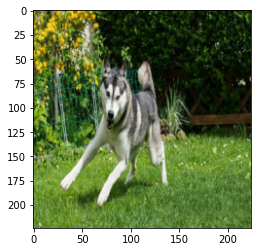

In [72]:
img, label = googles_dataset[70]
print(label)
plt.imshow(img.permute(1,2,0))

8


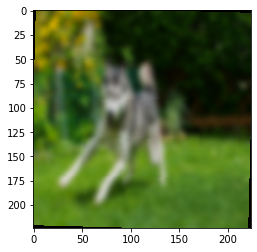

In [85]:
img, label = corrupt_googles_dataset[70]
print(label)
plt.imshow(img.permute(1,2,0))

In [86]:
google_dl = DataLoader(googles_dataset, 10, num_workers = 2, shuffle=True, pin_memory = True)
corrupt_google_dl = DataLoader(corrupt_googles_dataset, 10, num_workers = 2, shuffle=True, pin_memory = True)

In [88]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
google_dl = DeviceDataLoader(google_dl, device)
corrupt_google_dl = DeviceDataLoader(corrupt_google_dl, device)

cuda


In [81]:
# normal google non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = saved_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([2, 7, 0, 4, 9, 6, 3, 9, 7, 3], device='cuda:0')
['n02093428-American_Staffordshire_terrier', 'n02110063-malamute', 'n02085620-Chihuahua', 'n02099712-Labrador_retriever', 'n02113799-standard_poodle', 'n02107142-Doberman', 'n02097047-miniature_schnauzer', 'n02113799-standard_poodle', 'n02110063-malamute', 'n02097047-miniature_schnauzer']
['n02093428-American_Staffordshire_terrier', 'n02109961-Eskimo_dog', 'n02085620-Chihuahua', 'n02100236-German_short-haired_pointer', 'n02102973-Irish_water_spaniel', 'n02107142-Doberman', 'n02097047-miniature_schnauzer', 'n02113799-standard_poodle', 'n02110063-malamute', 'n02097047-miniature_schnauzer']
70.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([2, 5, 8, 5, 3, 0, 9, 5, 4, 1], device='cuda:0')
['n02093428-American_Staffordshire_terrier', 'n02106662-German_shepherd', 'n02110185-Siberian_husky', 'n02106662-German_shepherd', 'n02097047-miniature_schnauzer', 'n02085620-C

In [82]:
# normal google tented
def try_batch(batch):
        imgs, labels = batch
        # print("images shape : ", imgs.shape)
        # print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        # print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        # print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        # print(acc)
        return {'val_acc':acc, 'val_loss': 0}

to_device(tented_model, device)
outputss = [try_batch(batch) for batch in google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

val_acc: 58.05555555555556


In [89]:
# corrupt google non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = saved_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in corrupt_google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([9, 6, 5, 7, 1, 6, 3, 1, 8, 6], device='cuda:0')
['n02113799-standard_poodle', 'n02107142-Doberman', 'n02106662-German_shepherd', 'n02110063-malamute', 'n02091032-Italian_greyhound', 'n02107142-Doberman', 'n02097047-miniature_schnauzer', 'n02091032-Italian_greyhound', 'n02110185-Siberian_husky', 'n02107142-Doberman']
['n02105251-briard', 'n02107312-miniature_pinscher', 'n02097658-silky_terrier', 'n02110063-malamute', 'n02099849-Chesapeake_Bay_retriever', 'n02107312-miniature_pinscher', 'n02097047-miniature_schnauzer', 'n02097209-standard_schnauzer', 'n02105855-Shetland_sheepdog', 'n02107312-miniature_pinscher']
20.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([4, 3, 0, 1, 4, 8, 9, 4, 6, 6], device='cuda:0')
['n02099712-Labrador_retriever', 'n02097047-miniature_schnauzer', 'n02085620-Chihuahua', 'n02091032-Italian_greyhound', 'n02099712-Labrador_retriever', 'n02110185-Siberian_husky', 'n02113799-standard_p

In [103]:
# corrupt google tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [google_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
to_device(tented_model, device)
outputss = [try_batch(batch) for batch in corrupt_google_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([3, 5, 8, 8, 4, 0, 7, 8, 0, 2], device='cuda:0')
['n02097047-miniature_schnauzer', 'n02106662-German_shepherd', 'n02110185-Siberian_husky', 'n02110185-Siberian_husky', 'n02099712-Labrador_retriever', 'n02085620-Chihuahua', 'n02110063-malamute', 'n02110185-Siberian_husky', 'n02085620-Chihuahua', 'n02093428-American_Staffordshire_terrier']
['n02099712-Labrador_retriever', 'n02088466-bloodhound', 'n02110063-malamute', 'n02109961-Eskimo_dog', 'n02111277-Newfoundland', 'n02097298-Scotch_terrier', 'n02090622-borzoi', 'n02086240-Shih-Tzu', 'n02115913-dhole', 'n02093256-Staffordshire_bullterrier']
0.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([4, 0, 1, 9, 6, 3, 7, 6, 0, 4], device='cuda:0')
['n02099712-Labrador_retriever', 'n02085620-Chihuahua', 'n02091032-Italian_greyhound', 'n02113799-standard_poodle', 'n02107142-Doberman', 'n02097047-miniature_schnauzer', 'n02110063-malamute', 'n02107142-Doberman', 'n0208562

In [105]:
youtube_dataset = ImageFolder('./Images/test_yt')

In [106]:
youtubes_dataset = DogBreedDataset(youtube_dataset, test_transform)

In [107]:
youtube_dl = DataLoader(youtubes_dataset, 10, num_workers = 2, shuffle=True, pin_memory = True)


In [108]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
youtube_dl = DeviceDataLoader(youtube_dl, device)

cuda


In [110]:
# noncorrupt youtube non tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = saved_model(imgs)                                  # Change model object here
        # print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        # print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}

outputss = [try_batch(batch) for batch in youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([3, 9, 3, 5, 6, 8, 0, 1, 5, 6], device='cuda:0')
['n02097047-miniature_schnauzer', 'n02113799-standard_poodle', 'n02097047-miniature_schnauzer', 'n02106662-German_shepherd', 'n02107142-Doberman', 'n02110185-Siberian_husky', 'n02085620-Chihuahua', 'n02091032-Italian_greyhound', 'n02106662-German_shepherd', 'n02107142-Doberman']
['n02097209-standard_schnauzer', 'n02111889-Samoyed', 'n02097209-standard_schnauzer', 'n02108089-boxer', 'n02107142-Doberman', 'n02090622-borzoi', 'n02085620-Chihuahua', 'n02091032-Italian_greyhound', 'n02094433-Yorkshire_terrier', 'n02110806-basenji']
30.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([4, 7, 4, 3, 0, 5, 3, 0, 5, 1], device='cuda:0')
['n02099712-Labrador_retriever', 'n02110063-malamute', 'n02099712-Labrador_retriever', 'n02097047-miniature_schnauzer', 'n02085620-Chihuahua', 'n02106662-German_shepherd', 'n02097047-miniature_schnauzer', 'n02085620-Chihuahua', 'n02106662

In [116]:
# noncorrupt youtube tented
def try_batch(batch):
        imgs, labels = batch
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = tented_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        # print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        # print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        # print(labelslist)
        predlist = preds.detach().tolist()
        # print(predlist)

        labelslist = [youtube_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        acc = (((np.sum(labelsarray == predarray)) / len(preds)) * 100)
        print(acc)
        return {'val_acc':acc, 'val_loss': 0}
to_device(tented_model, device)
outputss = [try_batch(batch) for batch in youtube_dl]
batch_acc = [x['val_acc'] for x in outputss]
epoch_acc = statistics.mean(batch_acc)
print("val_acc: " + str(epoch_acc))

images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([8, 1, 6, 6, 8, 3, 8, 7, 1, 1], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02110185-Siberian_husky', 'n02091032-Italian_greyhound', 'n02107142-Doberman', 'n02107142-Doberman', 'n02110185-Siberian_husky', 'n02097047-miniature_schnauzer', 'n02110185-Siberian_husky', 'n02110063-malamute', 'n02091032-Italian_greyhound', 'n02091032-Italian_greyhound']
['n02113023-Pembroke', 'n02091032-Italian_greyhound', 'n02089078-black-and-tan_coonhound', 'n02100583-vizsla', 'n02109961-Eskimo_dog', 'n02102318-cocker_spaniel', 'n02113023-Pembroke', 'n02091467-Norwegian_elkhound', 'n02095570-Lakeland_terrier', 'n02088238-basset']
10.0
images shape :  torch.Size([10, 3, 224, 224])
labels :  tensor([9, 5, 5, 0, 9, 8, 6, 8, 7, 2], device='cuda:0')
outs.shape : torch.Size([10, 120])
preds.shape:  torch.Size([10])
['n02113799-standard_poodle', 'n02106662-German_shepherd', 'n02106662-German_shepherd', 'n02085